Project: /mediapipe/_project.yaml
Book: /mediapipe/_book.yaml

<link rel="stylesheet" href="/mediapipe/site.css">

# Image classification model customization guide

<table align="left" class="buttons">
  <td>
    <a href="https://colab.research.google.com/github/googlesamples/mediapipe/blob/main/examples/customization/image_classifier.ipynb" target="_blank">
      <img src="https://developers.google.com/static/mediapipe/solutions/customization/colab-logo-32px_1920.png" alt="Colab logo"> Run in Colab
    </a>
  </td>

  <td>
    <a href="https://github.com/googlesamples/mediapipe/blob/main/examples/customization/image_classifier.ipynb" target="_blank">
      <img src="https://developers.google.com/static/mediapipe/solutions/customization/github-logo-32px_1920.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

In [ ]:
#@title License information
# Copyright 2023 The MediaPipe Authors.
# Licensed under the Apache License, Version 2.0 (the "License");
#
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

The MediaPipe Model Maker package is a low-code solution for customizing on-device machine learning (ML) Models.

The MediaPipe image classification solution provides several models you can use immediately for machine learning (ML) in your application. However, if you need to classify images with content not covered by the provided models, you can customize any of the provided models with your own data and MediaPipe [Model Maker](https://developers.google.com/mediapipe/solutions/model_maker). This model modification tool rebuilds a portion of the model using data you provide. This method is faster than training a new model and can produce a model that is more useful for your specific application.

The following sections show you how to use Model Maker to retrain a pre-built model for image classification with your own data, which you can then use with the MediaPipe [Image Classifier](https://developers.google.com/mediapipe/solutions/vision/image_classifier). The example retrains a general purpose classification model to classify images of flowers.

This notebook shows the end-to-end process of customizing an ImageNet pretrained image classification model for recognizing flowers defined in a user customized flower dataset.

## Setup

This section describes key steps for setting up your development environment to retrain a model. These instructions describe how to update a model using [Google Colab](https://colab.research.google.com/), and you can also use Python in your own development environment. For general information on setting up your development environment for using MediaPipe, including platform version requirements, see the [Setup guide for Python](https://developers.google.com/mediapipe/solutions/setup_python).

To install the libraries for customizing a model, run the following commands:

In [1]:
!python --version
!pip install mediapipe-model-maker

Python 3.9.7


^C


Use the following code to import the required Python classes:

In [1]:
import os
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.config.list_physical_devices('GPU')

from mediapipe_model_maker import image_classifier

import matplotlib.pyplot as plt

c:\Users\mgagv\anaconda3\envs\tfenv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\mgagv\anaconda3\envs\tfenv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If yo

## Prepare data

Retraining a model for image classification requires a dataset that includes all kinds of items, or *classes*, that you want the completed model to be able to identify. You can do this by trimming down a public dataset to only the classes that are relevant to your usecase, compiling your own data, or some combination of both. The dataset can be significantly smaller that what would be required to train a new model. For example, the [ImageNet](https://www.image-net.org) dataset used to train many reference models contains millions of images with thousands of categories. Transfer learning with Model Maker can retrain an existing model with a smaller dataset and still perform well, depending on your inference accuracy goals. These instructions use a smaller dataset containing 5 types of flowers, or 5 _classes_, with 600 to 800 images per class.

To download the example dataset, use the following code:

In [2]:
# samples are in ./data/sorted1
image_path = os.path.join(os.getcwd(), os.path.normpath('data/sorted1'))
print(image_path)

f:\Projects\TensorKart-master\TensorKart-master\data\sorted1


This code stores the downloaded images at the directory location saved in the `image_path` variable. That directory contains several subdirectories, each corresponding to specific class labels. Your training data should also follow this pattern: `<image_path>/<label_name>/<image_names>.*`.


### Review data

When preparing data for training with Model Maker, you should review the training data to make sure it is in the proper format, correctly classified, and organized in directories corresponding to classification labels. *This step is optional, but recommended.*

The following code block retrieves all the label names from the expected directory structure at `image_path` and prints them.

In [3]:
print(image_path)
labels = []
for i in os.listdir(image_path):
  if os.path.isdir(os.path.join(image_path, i)):
    labels.append(i)
print(labels)

f:\Projects\TensorKart-master\TensorKart-master\data\sorted1
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']


You can review a few of the example images from each category using the following code:

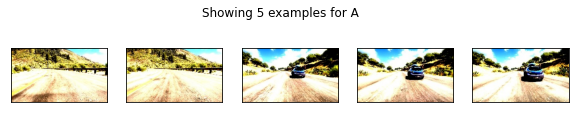

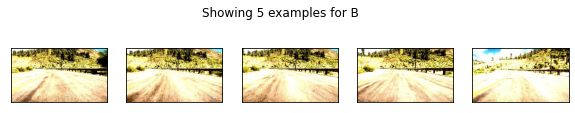

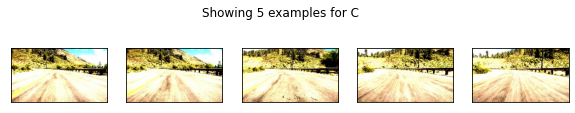

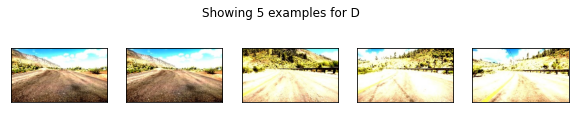

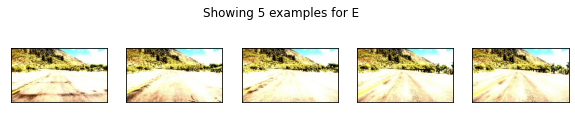

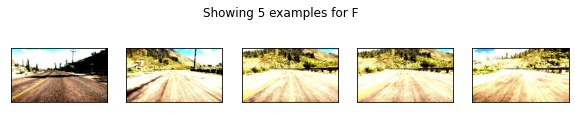

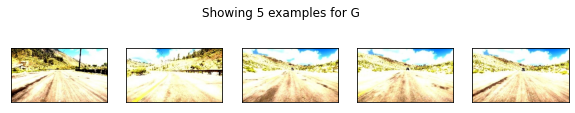

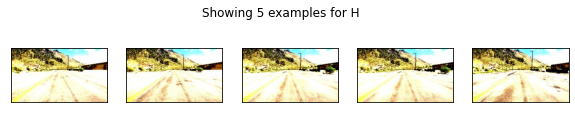

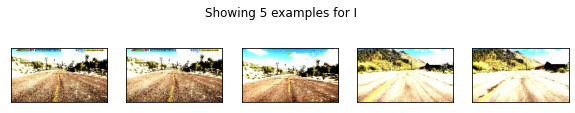

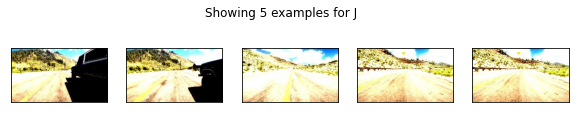

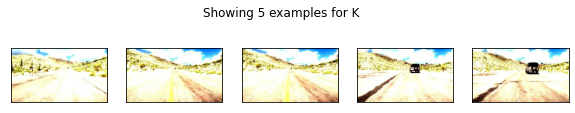

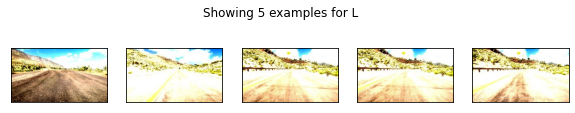

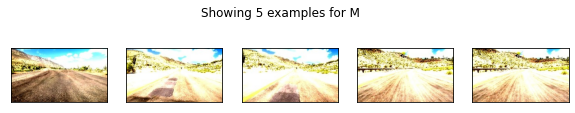

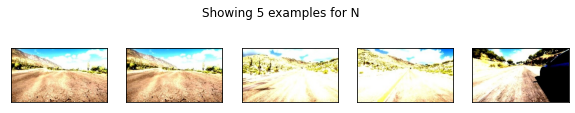

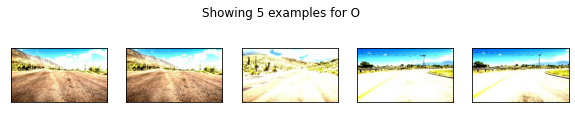

In [7]:
NUM_EXAMPLES = 5

for label in labels:
  label_dir = os.path.join(image_path, label)
  example_filenames = os.listdir(label_dir)[:NUM_EXAMPLES]
  fig, axs = plt.subplots(1, NUM_EXAMPLES, figsize=(10,2))
  for i in range(NUM_EXAMPLES):
    axs[i].imshow(plt.imread(os.path.join(label_dir, example_filenames[i])))
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(False)
  fig.suptitle(f'Showing {NUM_EXAMPLES} examples for {label}')

plt.show()

### Create dataset

Training data for machine learning can be large, consisting of hundreds or thousands of files which typically do not fit into available memory. You must also split it into groups for different uses: training, testing, and validation. For these reasons, Model Maker uses a `Dataset` class to organize training data and feed it to the retraining process.

To create a dataset, use the `Dataset.from_folder` method to load the data located at `image_path` and split it into training, testing, and validation groups:

In [4]:
data = image_classifier.Dataset.from_folder(image_path)
train_data, remaining_data = data.split(0.8)
test_data, validation_data = remaining_data.split(0.5)

INFO:tensorflow:Load image with size: 18457, num_label: 15, labels: A, B, C, D, E, F, G, H, I, J, K, L, M, N, O.


In this example, 80% of the data is used for training, with the remaining data split in half, so that 10% of the total is used for testing, and 10% for validation.

## Retrain model

Once you have completed preparing your data, you can begin retraining a model to build a new classification layer that can recognize the items types, or classes, defined by your training data. This type of model modification is called [transfer learning](https://www.wikipedia.org/wiki/Transfer_learning). The instructions below use the data prepared in the previous section to retrain an image classification model to recognize different types of flowers.

**Note:** For this type of model, the retraining process causes the model to forget any classes it was previously able to recognize. Once the retraining is complete, the new model can *only* recognize classes trained from the new dataset.

### Set retraining options

There are a few required settings to run a retraining aside from your training dataset: output directory for the model and the model architecture. Use `HParams` object `export_dir` parameter to specify a model output directory. Use the `SupportedModels` class to specify the model architecture. The image classifier solution supports the following model architectures:

- `MobileNet-V2`
- `EfficientNet-Lite0`
- `EfficientNet-Lite2`
- `EfficientNet-Lite4`

To set the required parameters, use the following code:

In [5]:
spec = image_classifier.SupportedModels.EFFICIENTNET_LITE2
hparams=image_classifier.HParams(epochs=3, shuffle=True, do_data_augmentation=False, export_dir="exported_model")
options = image_classifier.ImageClassifierOptions(supported_model=spec, hparams=hparams)

This example code uses MobileNetV2 model architecture, which you can learn more about from the  [MobileNetV2](https://arxiv.org/abs/1801.04381) research paper. The retraining process has many additional options, however most of them are set for you automatically. You can learn about these optional parameters in the [Retraining parameters](#retraining_parameters) section.

### Run retraining

With your training dataset and retraining options prepared, you are ready to start the retraining process. This process is resource intensive and can take a few minutes to a few hours depending on your available compute resources. Using a Google Colab environment with standard CPU processing, the example retraining below takes about 20 minutes to train on approximately 4000 images. You can typically decrease your training time by using GPU processors.

To begin the retraining process, use the `create()` method with dataset and options you previously defined:

In [6]:
model = image_classifier.ImageClassifier.create(
    train_data = train_data,
    validation_data = validation_data,
    options=options,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              4869168   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 4,888,383
Trainable params: 19,215
Non-trainable params: 4,869,168
_________________________________________________________________
None
INFO:tensorflow:Training the models...


INFO:tensorflow:Training the models...


INFO:tensorflow:Training the models...


INFO:tensorflow:Training the models...


Resuming from exported_model\checkpoint\model-0010
Epoch 1/3
7382/7382 [==============================] - 120s 16ms/step - loss: 2.5269 - accuracy: 0.2633 - val_loss: 2.4569 - val_accuracy: 0.2849
Epoch 2/3
7382/7382 [==============================] - 111s 15ms/step - loss: 2.5168 - accuracy: 0.2795 - val_loss: 2.4785 - val_accuracy: 0.2866
Epoch 3/3
7382/7382 [==============================] - 112s 15ms/step - loss: 2.5429 - accuracy: 0.2885 - val_loss: 2.5076 - val_accuracy: 0.2898


### Evaluate performance

After retraining the model, you should evaluate it on a test dataset, which is typically a portion of your original dataset not used during training. Accuracy levels between 0.8 and 0.9 are generally considered very good, but your use case requirements may differ. You should also consider how fast the model can produce an inference. Higher accuracy frequently comes at the cost of longer inference times.

To run an evaluation of the example model, run it against the test portion of the dataset:

In [11]:
loss, acc = model.evaluate(test_data)
print(f'Test loss:{loss}, Test accuracy:{acc}')

INFO:tensorflow:Use customized resize method bilinear


INFO:tensorflow:Use customized resize method bilinear


58/58 [==============================] - 5s 54ms/step - loss: 2.4294 - accuracy: 0.2822
Test loss:2.4294042587280273, Test accuracy:0.282231867313385


**Caution:** While high accuracy of a model is a common goal for machine learning models, you should be cautious of training to a point of [overfitting](https://en.wikipedia.org/wiki/Overfitting), which causes the model to perform extremely well with its training data, but quite poorly on new data.

## Export model

After retraining a model, you must export it to Tensorflow Lite model format to use it with the MediaPipe in your application. The export process generates required model metadata, as well as a classification label file.

To export the retrained model for use in your application, use the following command:

In [7]:
model.export_model()

INFO:tensorflow:Assets written to: C:\Users\mgagv\AppData\Local\Temp\tmperb4e299\saved_model\assets


INFO:tensorflow:Assets written to: C:\Users\mgagv\AppData\Local\Temp\tmperb4e299\saved_model\assets


INFO:tensorflow:TensorFlow Lite model exported successfully to: exported_model\model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully to: exported_model\model.tflite


## Model tuning

You can use the MediaPipe Model Maker tool to further improve and adjust the  model retraining with configuation options and performance techniques such as data quantization. *These steps are optional.* Model Maker uses reasonable default settings for all of the training configuration parameters, but if you want to further tune the model retraining, the instructions below describe the available options.

### Retraining parameters

You can further customize how the retraining process runs to adjust training time and potentially increase the retrained model's performance. *These parameters are optional*. Use the `ImageClassifierModelOptions` class and the `HParams` class to set these additional options.

Use the `ImageClassifierModelOptions` class parameters to customize the existing model. It has the following customizable parameter that affects model accuracy:
* `dropout_rate`: The fraction of the input units to drop. Used in dropout layer. Defaults to 0.05.

Use the `HParams` class to customize other parameters related to training and saving the model:

* `learning_rate`: The learning rate to use for gradient descent training. Defaults to 0.001.
* `batch_size`: Batch size for training. Defaults to 2.
* `epochs`: Number of training iterations over the dataset. Defaults to 10.
* `steps_per_epoch`: An optional integer that indicates the number of training steps per epoch. If not set, the training pipeline calculates the default steps per epoch as the training dataset size divided by batch size.
* `shuffle`: True if the dataset is shuffled before training. Defaults to False.
* `do_fine_tuning`: If true, the base module is trained together with the classification layer on top. This defaults to False, which means only the classification layer is trained and pre-trained weights for the base module are frozen.
* `l1_regularizer`: A regularizer that applies a L1 regularization penalty. Defaults to 0.0.
* `l2_regularizer`: A regularizer that applies a L2 regularization penalty. Defaults to 0.0001.
* `label_smoothing`: Amount of label smoothing to apply. See [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses) for more details. Defaults to 0.1.
* `do_data_augmentation`: Whether or not the training dataset is augmented by applying random transformations such as cropping, flipping, etc. See [utils.image_preprocessing](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image) for details. Defaults to True.
* `decay_samples`: Number of training samples used to calculate the decay steps and create the training optimizer. Defaults to 2,560,000.
* `warmup_epochs`: Number of warmup steps for a linear increasing warmup schedule on the learning rate. Used to set up warmup schedule by `model_util.WarmUp`. Defaults to 2.



The following example code trains a model with more epochs and a higher dropout rate:

In [ ]:
hparams=image_classifier.HParams(epochs=15, export_dir="exported_model_2")
options = image_classifier.ImageClassifierOptions(supported_model=spec, dropout_rate=0.07, hparams=hparams)
model_2 = image_classifier.ImageClassifier.create(
    train_data = train_data,
    validation_data = validation_data,
    options=options,
)

To evaluate the newly trained model above, use the following code:

In [ ]:
loss, accuracy = model_2.evaluate(test_data)

For more information on the general performance of the supported models, refer to the [Performance benchmarks](#performance_benchmarks) section.

### Model quantization

Post-training model quantization is a model modification technique that can reduce the model size and improve the speed of predictions with only a relatively minor decrease in accuracy. This approach reduces the size of the data processed by the model, for example by transforming 32-bit floating point numbers to 8-bit integers. This technique is widely used to further optimize models after the training process.

This section of the guide explains how to apply quantization to your retrained model. This optimization must be done as part of the Model Maker model export process, and cannot be performed on an exported model. The following example demonstrates how to use this approach to apply `int8` quantization to a retrained model. For more information on post-training quantization, see the [TensorFlow Lite](https://www.tensorflow.org/lite/performance/post_training_quantization) documentation.

Import the MediaPipe Model Maker quantization module:

In [ ]:
from mediapipe_model_maker import quantization

Define a `QuantizationConfig` object using the `for_int8()` class method. This configuration modifies a trained model to use 8-bit integers instead of larger data types, such as 32-bit floating point numbers. You can further customize the quantization process by setting additional parameters for the `QuantizationConfig` class.

In [ ]:
quantization_config = quantization.QuantizationConfig.for_int8(train_data)

The `for_int8()` method requires a representative dataset, while the `dynamic()` and `for_float16()` quantization methods do not. The quantization process uses the representative dataset to perform model modification and you typically use your existing training dataset for this purpose. For more information on the process and options, see the TensorFlow Lite [Post-training quantization](https://www.tensorflow.org/lite/performance/post_training_quantization) guide.

Export the model using the additional `quantization_config` object to apply post-training quantization:

In [ ]:
model.export_model(model_name="model_int8.tflite", quantization_config=quantization_config)

After running this command, you should have a new `model_int8.tflite` model file. This new, quantized model should be significantly smaller than the `model.tflite` file. You can compare the sizes using the following command:

In [ ]:
!ls -lh exported_model

## Performance benchmarks

Below is a summary of our benchmarking results for the supported model architectures. These models were trained and evaluated on the same flowers dataset as this notebook. When considering the model benchmarking results, there are a few important caveats to keep in mind:
- The test accuracy column reflects models which were trained with the default parameters. To optimize model performance, experiment with different model and retraining parameters in order to obtain the highest test accuracy. Refer to the [Retraining parameters](#retraining_parameters) section for more information on customizing these settings.
- The larger model architectures, such as EfficientNet_Lite4, may not acheive the highest test accuracy on simpler datasets like the flowers dataset used this notebook. Research suggests that these larger model architecture can outperform the others on more complex datasets like ImageNet, for more information, see [EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf). The ImageNet dataset is more complex, with over a million training images and 1000 classes, while the flowers dataset has only 3670 training images and 5 classses.

<table>
<thead>
<tr>
<th>Model architecture</th>
<th>Test Accuracy</th>
<th>Model Size</th>
<th>CPU 1 Thread Latency(Pixel 6)</th>
<th>GPU Latency(Pixel 6)</th>
<th>EdgeTPULatency(Pixel 6)</th>
</tr>
</thead>
<tbody>
<tr>
<td>MobileNet_V2</td>
<td>85.4%</td>
<td><strong>8.9MB</strong></td>
<td>29.12</td>
<td>77.77</td>
<td>31.14</td>
</tr>
<tr>
<td>EfficientNet_Lite0</td>
<td>91.3%</td>
<td>13.5MB</td>
<td><strong>15.6</strong></td>
<td><strong>9.25</strong></td>
<td><strong>16.72</strong></td>
</tr>
<tr>
<td>EfficientNet_Lite2</td>
<td><strong>91.5%</strong></td>
<td>19.2MB</td>
<td>35.2</td>
<td>13.94</td>
<td>37.52</td>
</tr>
<tr>
<td>EfficientNet_Lite4</td>
<td>90.8%</td>
<td>46.8MB</td>
<td>103.16</td>
<td>23.14</td>
<td>114.67</td>
</tr>
</tbody>
</table>